# UT-EndoMRI Dataset Exploration

This notebook provides an exploratory analysis of the UT-EndoMRI dataset for endometriosis segmentation.

**Contents:**
1. Dataset Overview
2. Load and Visualize MRI Scans
3. Analyze Label Statistics
4. Intensity Distribution Analysis
5. Inter-rater Agreement (Dataset 1)
6. Class Imbalance Analysis

In [1]:
# Use this cell for quick re-setup in future sessions
import torch

# Mount Drive

from google.colab import drive
drive.mount('/content/drive')

%cd /content
!git clone -b refactor-structure https://github.com/sehajbath/endo-seg.git
%cd endo-seg

import sys
sys.path.append('/content/endo-seg/src')

print("Quick setup complete!")
print(f"GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")

!pip install -r requirements.txt
!pip install -e .

!python scripts/create_splits.py \
    --data_root /content/drive/MyDrive/UT-EndoMRI \
    --dataset D2_TCPW \
    --output data/splits/split_info.json \
    --use_paper_split

Mounted at /content/drive
/content
Cloning into 'endo-seg'...
remote: Enumerating objects: 112, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 112 (delta 34), reused 100 (delta 22), pack-reused 0 (from 0)
Receiving objects: 100% (112/112), 976.20 KiB | 3.56 MiB/s, done.
Resolving deltas: 100% (34/34), done.
/content/endo-seg
Quick setup complete!
GPU: None
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.4/832.4 kB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 89.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━

Obtaining file:///content/endo-seg
  Preparing metadata (setup.py) ... done
  Running setup.py develop for endo-uncertainty-seg
2025-10-17 04:40:16,217 - __main__ - INFO - ============================================================
2025-10-17 04:40:16,217 - __main__ - INFO - Creating Data Splits
2025-10-17 04:40:16,217 - __main__ - INFO - ============================================================
2025-10-17 04:40:16,217 - __main__ - INFO - Using exact split from paper
2025-10-17 04:40:16,217 - __main__ - INFO - Train: 6 subjects
2025-10-17 04:40:16,218 - __main__ - INFO - Val: 2 subjects
2025-10-17 04:40:16,218 - __main__ - INFO - Test: 30 subjects
2025-10-17 04:40:16,218 - __main__ - INFO - ============================================================
2025-10-17 04:40:16,218 - __main__ - INFO - Splits saved to: data/splits/split_info.json
2025-10-17 04:40:16,218 - __main__ - INFO - ============================================================

Split Summary:
  Dataset: D2_TCPW
  Trai

In [2]:
# Imports
import sys
sys.path.append('/content/endo-seg/src')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
import json

from endo_seg.data import (
    load_nifti,
    get_dataset_statistics,
    parse_filename,
    get_subject_files,
    load_data_splits,
)

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 8)

print('Imports successful!')

Imports successful!


## 1. Dataset Overview

In [3]:
# Set paths
data_root = "/content/drive/MyDrive/UT-EndoMRI"

# Get statistics for both datasets
print("Dataset 1 (D1_MHS - Multi-center, Multi-rater):")
print("="*60)
stats_d1 = get_dataset_statistics(data_root, "D1_MHS")
print(json.dumps(stats_d1, indent=2))

print("\n\nDataset 2 (D2_TCPW - Single-center, Single-rater):")
print("="*60)
stats_d2 = get_dataset_statistics(data_root, "D2_TCPW")
print(json.dumps(stats_d2, indent=2))

Dataset 1 (D1_MHS - Multi-center, Multi-rater):
{
  "num_subjects": 51,
  "sequences": [
    "T1FS",
    "T2"
  ],
  "structures": [
    "em",
    "ov",
    "ut"
  ],
  "raters": [
    "r1",
    "r2",
    "r3",
    "re3"
  ]
}


Dataset 2 (D2_TCPW - Single-center, Single-rater):
{
  "num_subjects": 73,
  "sequences": [
    "T1",
    "T1FS",
    "T2",
    "T2FS"
  ],
  "structures": [
    "cy",
    "em",
    "ov",
    "ut"
  ],
  "raters": []
}


## 2. Load and Visualize MRI Scans

In [4]:
# Load a sample subject from Dataset 2
subject_dir = Path(data_root) / "D2_TCPW" / "D2-000"
files = get_subject_files(subject_dir)

# Load T2FS image
image_file = [f for f in files['images'] if 'T2FS' in f.name][0]
image_data, image_obj = load_nifti(str(image_file))

# Load labels
label_files = {f.name.split('_')[1].replace('.nii.gz', ''): f for f in files['labels']}

print(f"Image shape: {image_data.shape}")
print(f"Image spacing: {np.abs(np.diag(image_obj.affine)[:3])} mm")
print(f"Intensity range: [{image_data.min():.2f}, {image_data.max():.2f}]")
print(f"Available labels: {list(label_files.keys())}")

Image shape: (352, 352, 36)
Image spacing: [0.68178135 0.68178868 5.99992371] mm
Intensity range: [0.00, 3181.12]
Available labels: ['cy', 'ov', 'ut']


Visualizing T2FS image with uterus label overlay:


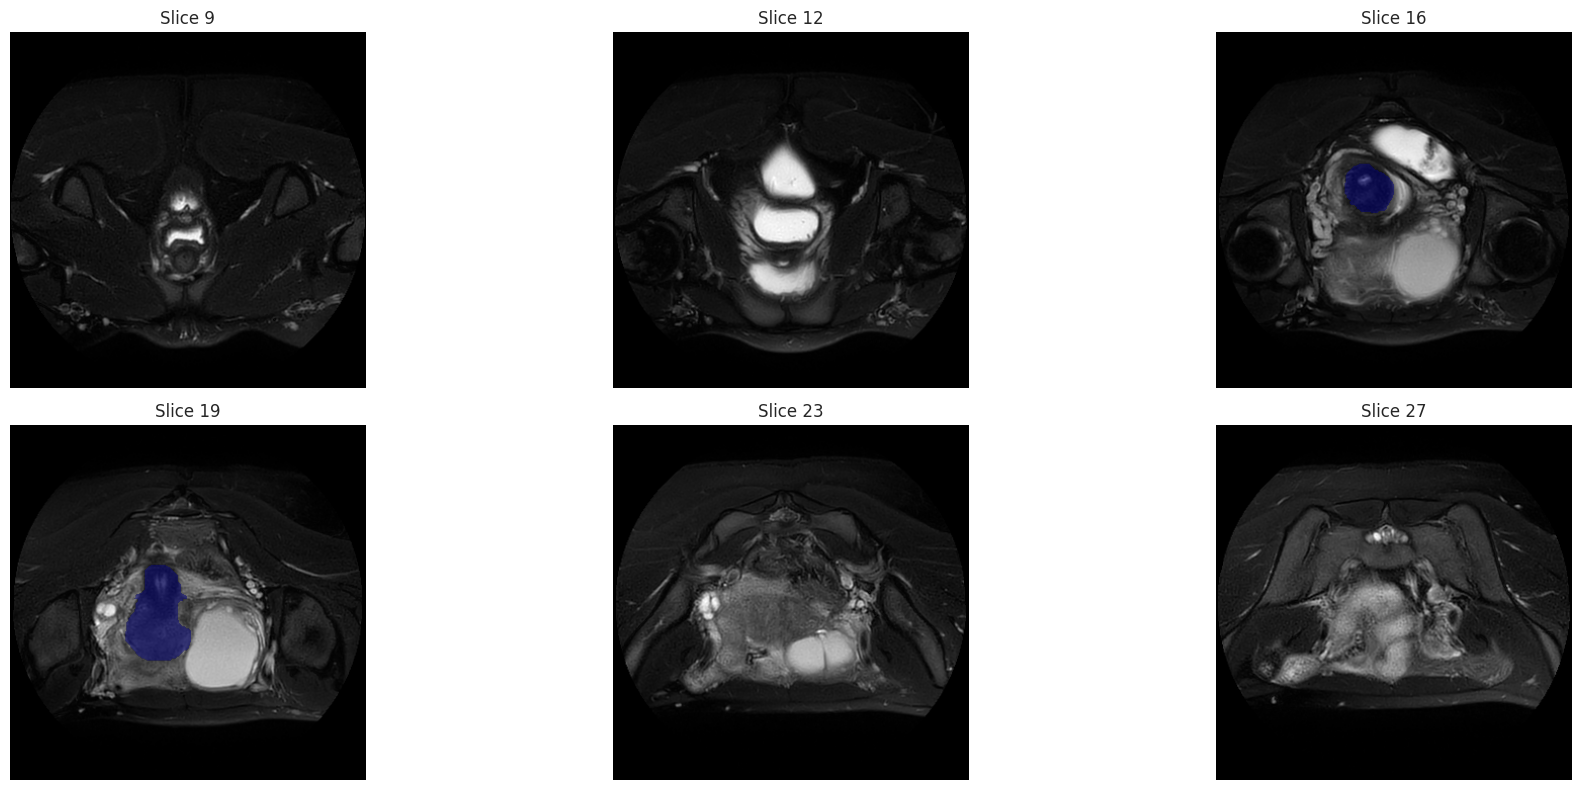

In [5]:
# Visualize multiple slices
def visualize_slices(image, label=None, num_slices=6, cmap='gray'):
    """Visualize multiple slices from 3D volume"""
    depth = image.shape[2]
    slice_indices = np.linspace(depth//4, 3*depth//4, num_slices, dtype=int)

    fig, axes = plt.subplots(2, num_slices//2, figsize=(20, 8))
    axes = axes.flatten()

    for idx, slice_idx in enumerate(slice_indices):
        axes[idx].imshow(image[:, :, slice_idx].T, cmap=cmap, origin='lower')

        if label is not None:
            # Overlay label
            label_slice = label[:, :, slice_idx].T
            masked = np.ma.masked_where(label_slice == 0, label_slice)
            axes[idx].imshow(masked, cmap='jet', alpha=0.5, origin='lower')

        axes[idx].set_title(f'Slice {slice_idx}')
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

# Load uterus label
if 'ut' in label_files:
    ut_label, _ = load_nifti(str(label_files['ut']))
    print("Visualizing T2FS image with uterus label overlay:")
    visualize_slices(image_data, ut_label)
else:
    print("Visualizing T2FS image only:")
    visualize_slices(image_data)

## 3. Label Statistics and Volume Analysis

In [6]:
# Collect volume statistics for all structures
def collect_volumes(data_root, dataset_name):
    """Collect volume statistics for all structures"""
    from collections import defaultdict

    dataset_path = Path(data_root) / dataset_name
    volumes = defaultdict(list)

    for subject_dir in dataset_path.iterdir():
        if not subject_dir.is_dir():
            continue

        files = get_subject_files(subject_dir)

        for label_file in files['labels']:
            info = parse_filename(label_file.name)
            struct_type = info['type']

            try:
                data, img = load_nifti(str(label_file))
                spacing = np.abs(np.diag(img.affine)[:3])
                voxel_volume = np.prod(spacing)
                num_voxels = np.sum(data > 0)
                volume_cc = (num_voxels * voxel_volume) / 1000

                if volume_cc > 0:
                    volumes[struct_type].append(volume_cc)
            except:
                continue

    return volumes

# Collect volumes
print("Collecting volume statistics for Dataset 1...")
volumes_d1 = collect_volumes(data_root, "D1_MHS")

# Create DataFrame
volume_data = []
for struct, vols in volumes_d1.items():
    for vol in vols:
        volume_data.append({'Structure': struct, 'Volume (cc)': vol})

df_volumes = pd.DataFrame(volume_data)

# Summary statistics
print("\nVolume Statistics Summary:")
print(df_volumes.groupby('Structure')['Volume (cc)'].describe())


Volume Statistics Summary:
           count        mean         std           min        25%         50%  \
Structure                                                                       
em          69.0   86.097689  220.641976  1.061616e-06   6.633398   21.259020   
ov          67.0   19.806123   31.394459  2.076800e-10   5.072011   10.504363   
ut          77.0  200.834686  221.844428  4.306354e-09  70.745795  153.376191   

                  75%          max  
Structure                           
em          82.407688  1328.017847  
ov          20.511876   205.132222  
ut         208.757111  1012.145250  


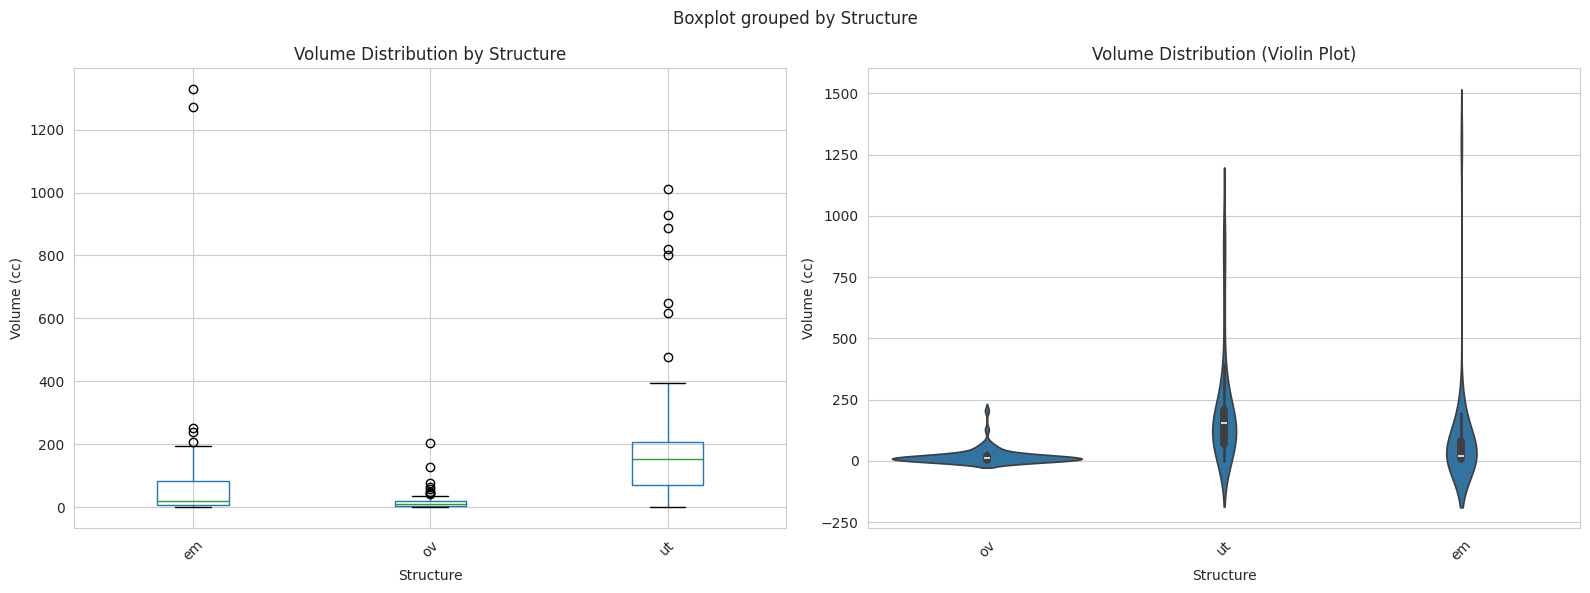


Key Insights:
- Uterus is the largest structure (mean: 200.8 cc)
- Ovaries are much smaller (mean: 19.8 cc)
- Endometriomas when present (mean: 86.1 cc)


In [7]:
# Visualize volume distributions
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Box plot
df_volumes.boxplot(column='Volume (cc)', by='Structure', ax=axes[0])
axes[0].set_title('Volume Distribution by Structure')
axes[0].set_ylabel('Volume (cc)')
axes[0].set_xlabel('Structure')
plt.sca(axes[0])
plt.xticks(rotation=45)

# Violin plot
sns.violinplot(data=df_volumes, x='Structure', y='Volume (cc)', ax=axes[1])
axes[1].set_title('Volume Distribution (Violin Plot)')
axes[1].set_xlabel('Structure')
axes[1].set_ylabel('Volume (cc)')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Print key insights
print("\nKey Insights:")
print(f"- Uterus is the largest structure (mean: {df_volumes[df_volumes['Structure']=='ut']['Volume (cc)'].mean():.1f} cc)")
print(f"- Ovaries are much smaller (mean: {df_volumes[df_volumes['Structure']=='ov']['Volume (cc)'].mean():.1f} cc)")
if 'em' in volumes_d1:
    print(f"- Endometriomas when present (mean: {df_volumes[df_volumes['Structure']=='em']['Volume (cc)'].mean():.1f} cc)")

## 4. Intensity Distribution Analysis

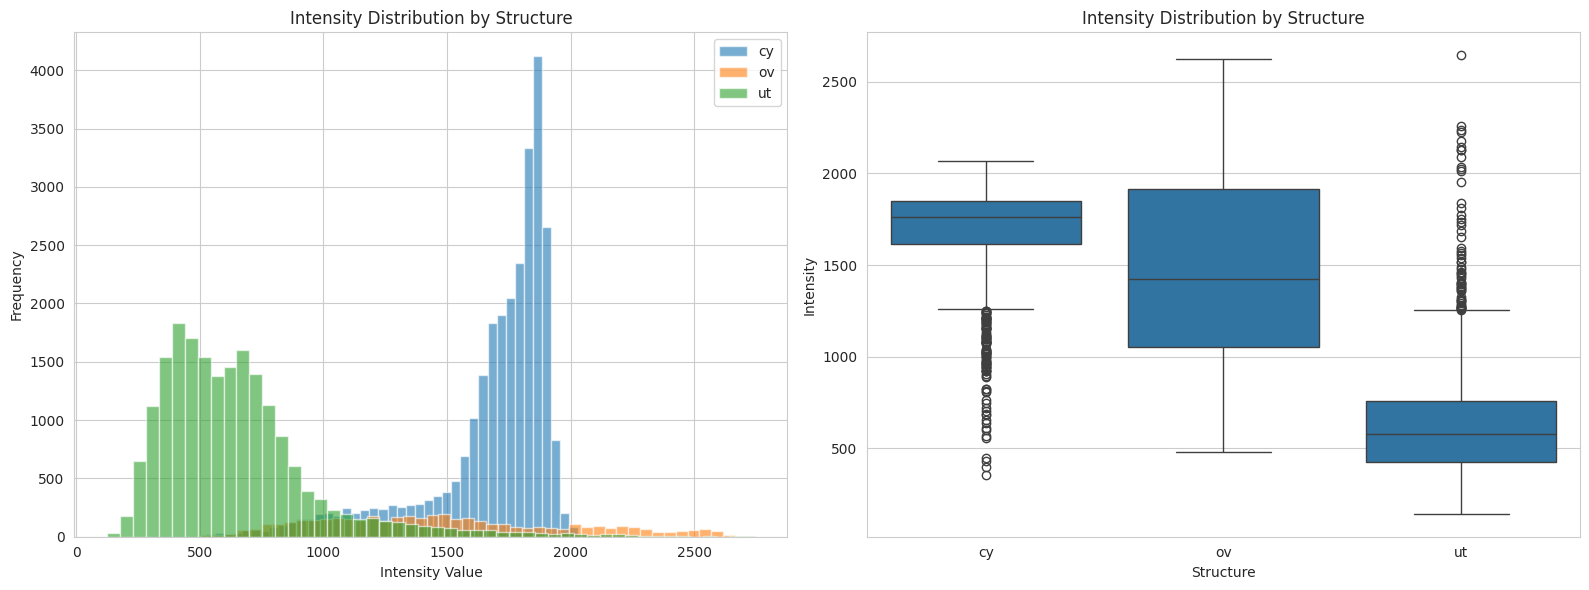


Intensity Statistics:

cy:
  Mean: 1681.39
  Std: 266.28
  Range: [304.21, 2142.47]

ov:
  Mean: 1489.19
  Std: 505.59
  Range: [266.54, 2665.42]

ut:
  Mean: 646.45
  Std: 320.52
  Range: [124.58, 2746.54]


In [10]:
# Analyze intensity distributions within different structures
def analyze_intensities(image, labels_dict):
    """Extract intensity statistics for each structure"""
    intensities = {}

    for name, label in labels_dict.items():
        mask = label > 0
        if np.any(mask):
            intensities[name] = image[mask]

    return intensities

# Load multiple labels for current subject
labels_dict = {}
for name, file_path in label_files.items():
    label_data, _ = load_nifti(str(file_path))
    labels_dict[name] = label_data

# Get intensities
intensities = analyze_intensities(image_data, labels_dict)

# Plot intensity distributions
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram
for name, values in intensities.items():
    axes[0].hist(values.flatten(), bins=50, alpha=0.6, label=name)
axes[0].set_xlabel('Intensity Value')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Intensity Distribution by Structure')
axes[0].legend()

# Box plot
intensity_data = []
for name, values in intensities.items():
    sample = np.random.choice(values.flatten(), min(1000, len(values.flatten())))
    for val in sample:
        intensity_data.append({'Structure': name, 'Intensity': val})

df_intensity = pd.DataFrame(intensity_data)
sns.boxplot(data=df_intensity, x='Structure', y='Intensity', ax=axes[1])
axes[1].set_title('Intensity Distribution by Structure')
axes[1].set_xlabel('Structure')
axes[1].set_ylabel('Intensity')

plt.tight_layout()
plt.show()

# Print statistics
print("\nIntensity Statistics:")
for name, values in intensities.items():
    print(f"\n{name}:")
    print(f"  Mean: {values.mean():.2f}")
    print(f"  Std: {values.std():.2f}")
    print(f"  Range: [{values.min():.2f}, {values.max():.2f}]")

### Z-Score Normalized Intensity Comparison Across Sequences

We pull representative T1-weighted (`*_T1.nii.gz`), T2-weighted (`*_T2.nii.gz`), and T1 fat-suppressed (`*_T1FS.nii.gz`) volumes using the naming rule `D[dataset ID]-[patient ID]_[MRI sequence].nii.gz`. Each volume is z-score normalized independently before overlaying their intensity histograms to inspect scanner-dependent trends.


In [ ]:
# Apply z-score normalization and plot overlapping histograms for key sequences
from collections import OrderedDict

def zscore_normalize(volume, eps=1e-6):
    volume = volume.astype(np.float32)
    mean = volume.mean()
    std = volume.std()
    if std < eps:
        return np.zeros_like(volume), mean, std
    return (volume - mean) / std, mean, std

sequence_patterns = OrderedDict([
    ("T1-weighted", "*_T1.nii.gz"),
    ("T2-weighted", "*_T2.nii.gz"),
    ("T1 fat-suppressed", "*_T1FS.nii.gz"),
])
search_order = ["D2_TCPW", "D1_MHS"]

normalized_sequences = {}
normalization_stats = {}
selected_files = {}

for seq_name, pattern in sequence_patterns.items():
    found_file = None
    for dataset_name in search_order:
        dataset_dir = Path(data_root) / dataset_name
        matches = sorted(dataset_dir.rglob(pattern))
        if matches:
            found_file = matches[0]
            break
    if found_file is None:
        print(f"Warning: no volume found for pattern {pattern}; skipping {seq_name}.")
        continue

    volume, _ = load_nifti(str(found_file))
    normalized, mean, std = zscore_normalize(volume)
    normalized_sequences[seq_name] = normalized
    normalization_stats[seq_name] = {"mean": float(mean), "std": float(std)}
    selected_files[seq_name] = str(found_file)

plt.figure(figsize=(12, 6))
colors = {
    "T1-weighted": "#1f77b4",
    "T2-weighted": "#ff7f0e",
    "T1 fat-suppressed": "#2ca02c",
}
max_voxels = 500_000

for seq_name, normalized in normalized_sequences.items():
    values = normalized.ravel()
    if values.size > max_voxels:
        idx = np.random.choice(values.size, max_voxels, replace=False)
        values = values[idx]
    plt.hist(values, bins=120, density=True, alpha=0.4, label=seq_name, color=colors.get(seq_name, None))

plt.title("Z-Score Normalized Intensity Histograms Across Sequences")
plt.xlabel("Normalized Intensity")
plt.ylabel("Density")
plt.legend()
plt.grid(alpha=0.3)

print("Normalization parameters (mean, std) before z-score:")
for seq_name, stats in normalization_stats.items():
    print(f"  {seq_name}: mean={stats['mean']:.2f}, std={stats['std']:.2f}")

print("Sampled volumes:")
for seq_name, file_path in selected_files.items():
    print(f"  {seq_name}: {file_path}")


## 5. Class Imbalance Analysis

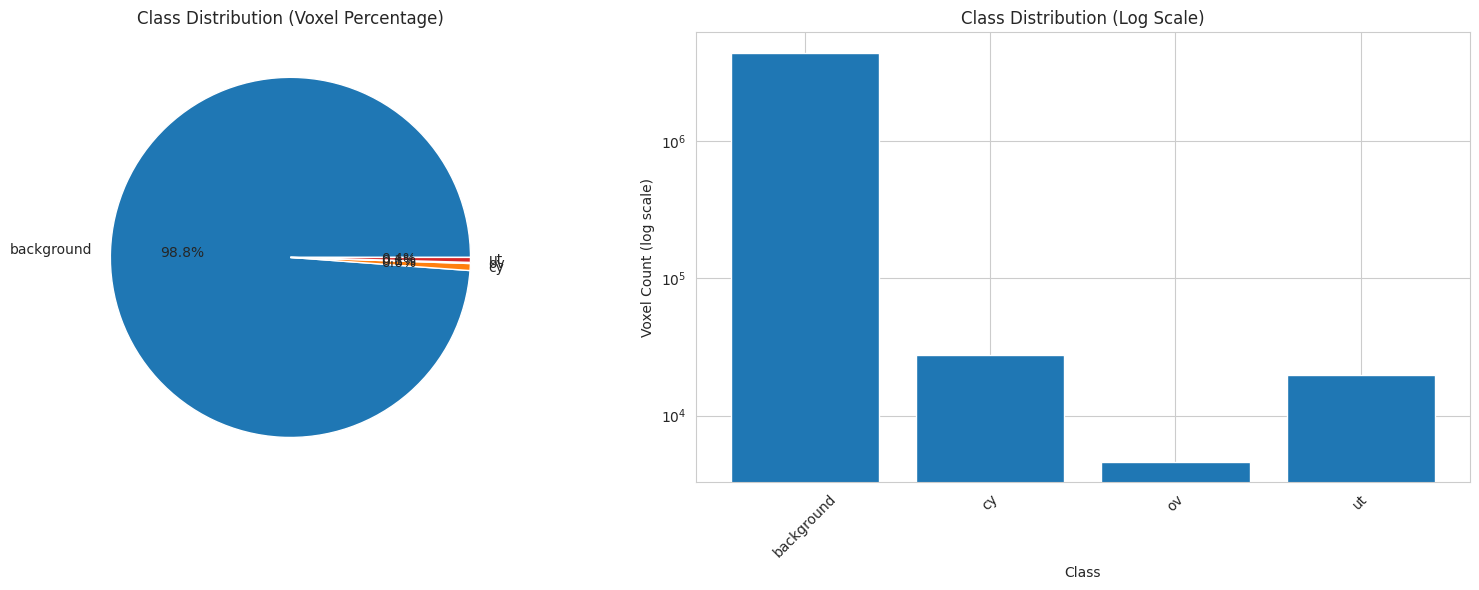


Class Imbalance Statistics:
background: 4408576 voxels (98.83%)
cy: 27777 voxels (0.62%)
ov: 4584 voxels (0.10%)
ut: 19611 voxels (0.44%)

Background/Foreground ratio: 84.83:1


In [11]:
# Analyze class distribution in labels
def compute_class_distribution(labels_dict):
    """Compute voxel counts for each structure"""
    class_dist = {}

    # Get total volume size
    total_voxels = list(labels_dict.values())[0].size

    # Count background (everything not labeled)
    all_labels = np.zeros_like(list(labels_dict.values())[0])
    for label in labels_dict.values():
        all_labels = np.logical_or(all_labels, label > 0)

    class_dist['background'] = total_voxels - np.sum(all_labels)

    # Count each structure
    for name, label in labels_dict.items():
        class_dist[name] = np.sum(label > 0)

    return class_dist

# Compute distribution
class_dist = compute_class_distribution(labels_dict)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Pie chart
axes[0].pie(class_dist.values(), labels=class_dist.keys(), autopct='%1.1f%%')
axes[0].set_title('Class Distribution (Voxel Percentage)')

# Bar chart (log scale)
names = list(class_dist.keys())
counts = list(class_dist.values())
axes[1].bar(names, counts)
axes[1].set_yscale('log')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Voxel Count (log scale)')
axes[1].set_title('Class Distribution (Log Scale)')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Print statistics
print("\nClass Imbalance Statistics:")
total = sum(class_dist.values())
for name, count in class_dist.items():
    percentage = (count / total) * 100
    print(f"{name}: {count} voxels ({percentage:.2f}%)")

# Compute imbalance ratio
foreground_voxels = sum([v for k, v in class_dist.items() if k != 'background'])
background_voxels = class_dist['background']
imbalance_ratio = background_voxels / foreground_voxels
print(f"\nBackground/Foreground ratio: {imbalance_ratio:.2f}:1")

## 6. Train/Val/Test Split Analysis

Data Split Information:

Dataset: D2_TCPW
Random seed: 42

Split sizes:
  Train: 6 subjects (15.8%)
  Val: 2 subjects (5.3%)
  Test: 30 subjects (78.9%)


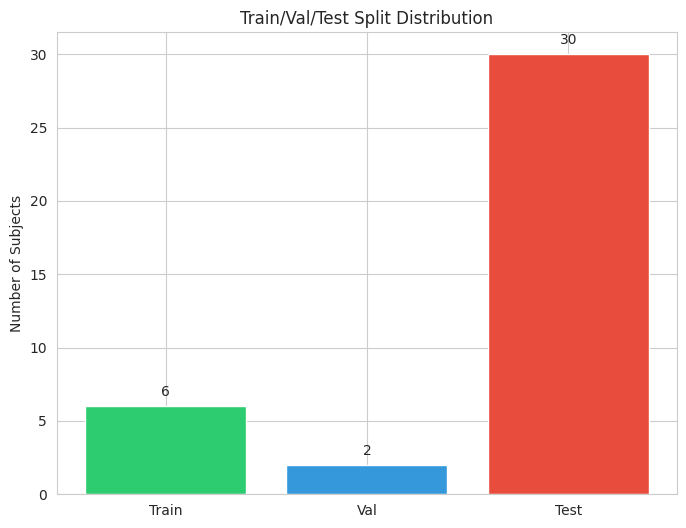

In [14]:
# Load splits
splits_file = "/content/endo-seg/data/splits/split_info.json"
if Path(splits_file).exists():
    splits = load_data_splits(splits_file)

    print("Data Split Information:")
    print(f"\nDataset: {splits['dataset']}")
    print(f"Random seed: {splits['seed']}")
    print(f"\nSplit sizes:")
    print(f"  Train: {len(splits['train'])} subjects ({splits['ratios']['train']:.1%})")
    print(f"  Val: {len(splits['val'])} subjects ({splits['ratios']['val']:.1%})")
    print(f"  Test: {len(splits['test'])} subjects ({splits['ratios']['test']:.1%})")

    # Visualize
    fig, ax = plt.subplots(figsize=(8, 6))
    splits_counts = [len(splits['train']), len(splits['val']), len(splits['test'])]
    ax.bar(['Train', 'Val', 'Test'], splits_counts, color=['#2ecc71', '#3498db', '#e74c3c'])
    ax.set_ylabel('Number of Subjects')
    ax.set_title('Train/Val/Test Split Distribution')
    for i, v in enumerate(splits_counts):
        ax.text(i, v + 0.5, str(v), ha='center', va='bottom')
    plt.show()
else:
    print("Split file not found. Run: python scripts/create_splits.py")

## Summary and Key Findings

From this exploratory analysis, we can conclude:

1. **Dataset Composition:**
   ---

2. **Structure Sizes:**
   - Uterus is the largest structure (~200 cc)
   - Ovaries are much smaller (~20 cc)
   - This size difference contributes to segmentation difficulty

3. **Class Imbalance:**
   - Significant imbalance between background and foreground
   - Important for loss function design (Focal Loss, Tversky Loss)

4. **Inter-rater Variability:**
   ---

5. **Next Steps:**
   - Implement preprocessing pipeline
   - Design appropriate loss functions
   - Develop uncertainty-aware model architecture